# Clasificación Multi-Label - Pascal 2007
**Clases:** person, chair, dog, sofa

In [ ]:
!pip install -q mlflow pillow ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.7/796.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.7 MB/s eta 0:00:00


In [ ]:
import os, gc, io, tarfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score

import tensorflow as tf
print(f"TensorFlow: {tf.__version__}")

# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU: {gpus if gpus else 'No detectada - habilitar en Entorno de ejecución'}")

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Configuración
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
TARGET_CLASSES = ['person', 'chair', 'dog', 'sofa']
NUM_CLASSES = 4

## Descargar Dataset

In [ ]:
data_dir = "pascal_2007"
if not os.path.exists(data_dir):
    print("Descargando...")
    urllib.request.urlretrieve("https://s3.amazonaws.com/fast-ai-imagelocal/pascal_2007.tgz", "pascal.tgz")
    with tarfile.open("pascal.tgz", "r:gz") as tar:
        tar.extractall()
    os.remove("pascal.tgz")
print("Dataset listo")

Descargando...


/tmp/ipython-input-3070048769.py:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Dataset listo


## Análisis y Filtrado

In [ ]:
df = pd.read_csv(os.path.join(data_dir, "train.csv"))
print(f"Total imágenes: {len(df)}")

# Contar clases
all_labels = set()
for lbls in df['labels'].str.split():
    all_labels.update(lbls)
print(f"Clases: {len(all_labels)} - {sorted(all_labels)}")

Total imágenes: 5011
Clases: 20 - ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


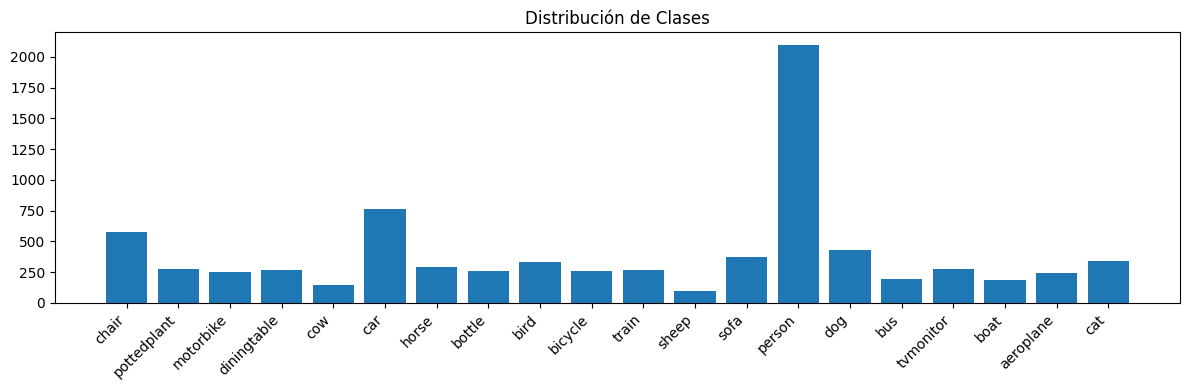

In [ ]:
# Visualizar distribución
counts = {l: sum(1 for x in df['labels'] if l in x.split()) for l in all_labels}
plt.figure(figsize=(12, 4))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Clases')
plt.tight_layout()
plt.show()

Filtradas: 2791 imágenes


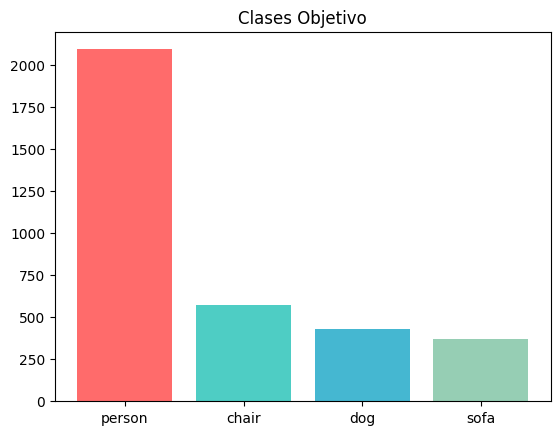

In [ ]:
# Filtrar solo clases objetivo
def has_target(labels_str):
    return any(l in TARGET_CLASSES for l in labels_str.split())

def get_vector(labels_str):
    lbls = labels_str.split()
    return [1.0 if c in lbls else 0.0 for c in TARGET_CLASSES]

filtered = df[df['labels'].apply(has_target)].reset_index(drop=True)
print(f"Filtradas: {len(filtered)} imágenes")

# Visualizar clases filtradas
tcounts = {l: sum(1 for x in filtered['labels'] if l in x.split()) for l in TARGET_CLASSES}
plt.bar(tcounts.keys(), tcounts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Clases Objetivo')
plt.show()

## Cargar Imágenes como Arrays Numpy

In [ ]:
img_dir = os.path.join(data_dir, "train")

# Cargar TODAS las imágenes y etiquetas como numpy arrays puros
all_images = []
all_labels = []

print("Cargando imágenes...")
for i, row in filtered.iterrows():
    path = os.path.join(img_dir, row['fname'])
    if os.path.exists(path):
        img = Image.open(path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        all_images.append(np.array(img, dtype=np.float32) / 255.0)
        all_labels.append(get_vector(row['labels']))
    if (i + 1) % 500 == 0:
        print(f"  {i + 1}/{len(filtered)}")

# Convertir a numpy arrays
X_all = np.array(all_images, dtype=np.float32)
y_all = np.array(all_labels, dtype=np.float32)

print(f"\n✅ X: {X_all.shape}, y: {y_all.shape}")
print(f"X dtype: {X_all.dtype}, y dtype: {y_all.dtype}")

Cargando imágenes...
  500/2791
  1000/2791
  1500/2791
  2000/2791
  2500/2791

✅ X: (2791, 224, 224, 3), y: (2791, 4)
X dtype: float32, y dtype: float32


In [ ]:
# Dividir datos
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

# Liberar memoria
del all_images, all_labels, X_all, y_all, X_temp, y_temp
gc.collect()

Train: (1953, 224, 224, 3) | Val: (419, 224, 224, 3) | Test: (419, 224, 224, 3)


5466

## Verificar Datos

In [ ]:
# VERIFICACIÓN CRÍTICA - asegurar que no hay strings
print("Verificando tipos de datos:")
print(f"  X_train: {X_train.dtype} (debe ser float32)")
print(f"  y_train: {y_train.dtype} (debe ser float32)")
print(f"  X_val: {X_val.dtype}")
print(f"  y_val: {y_val.dtype}")

assert X_train.dtype == np.float32, "ERROR: X_train no es float32"
assert y_train.dtype == np.float32, "ERROR: y_train no es float32"
print("\n Todos los datos son float32 - listo para entrenar")

Verificando tipos de datos:
  X_train: float32 (debe ser float32)
  y_train: float32 (debe ser float32)
  X_val: float32
  y_val: float32

 Todos los datos son float32 - listo para entrenar


## MLflow y Modelos

In [ ]:
import mlflow
import mlflow.keras
from tensorflow import keras
from tensorflow.keras import layers

#  CONFIGURAR DIRECTORIO PERSISTENTE PARA MLFLOW
mlflow_dir = "./mlruns"
os.makedirs(mlflow_dir, exist_ok=True)
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")
print(f" MLflow guardando en: {os.path.abspath(mlflow_dir)}")

# Crear/obtener experimento
experiment_name = "MultiLabel_Pascal2007"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
mlflow.set_experiment(experiment_name)
print(f" Experimento: {experiment_name} (ID: {experiment_id})")

def create_model(base_name):
    """Crea modelo con transfer learning."""
    if base_name == "ResNet50":
        base = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_name == "EfficientNetB0":
        base = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:  # MobileNetV2
        base = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    base.trainable = False

    model = keras.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='sigmoid')
    ], name=base_name)

    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model, base

def get_metrics(model, X, y):
    """Calcula métricas."""
    pred = (model.predict(X, verbose=0) >= 0.5).astype(int)
    return {
        'accuracy': accuracy_score(y.flatten(), pred.flatten()),
        'precision': precision_score(y, pred, average='macro', zero_division=0),
        'recall': recall_score(y, pred, average='macro', zero_division=0),
        'f1_score': f1_score(y, pred, average='macro', zero_division=0),
        'hamming_loss': hamming_loss(y, pred)
    }

def train_and_evaluate(name):
    """Entrena y evalúa un modelo."""
    print(f"\n{'='*50}\n  {name}\n{'='*50}")

    model, base = create_model(name)

    callbacks = [
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]

    with mlflow.start_run(run_name=name):
        # ✅ REGISTRAR PARÁMETROS DEL MODELO
        mlflow.log_param("model", name)
        mlflow.log_param("img_size", IMG_SIZE)
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("epochs", EPOCHS)
        mlflow.log_param("classes", TARGET_CLASSES)
        mlflow.log_param("num_classes", NUM_CLASSES)

        # ENTRENAR CON NUMPY ARRAYS DIRECTAMENTE
        history = model.fit(
            x=X_train,
            y=y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )

        # ✅ REGISTRAR MÉTRICAS DE ENTRENAMIENTO
        for epoch in range(len(history.history['loss'])):
            mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
            mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

        # Calcular métricas de test
        metrics = get_metrics(model, X_test, y_test)

        # ✅ REGISTRAR MÉTRICAS FINALES CON PREFIJO TEST
        for key, value in metrics.items():
            mlflow.log_metric(f"test_{key}", value)

        # ✅ GUARDAR MODELO CON ARTIFACT_PATH CORRECTO
        mlflow.keras.log_model(model, artifact_path="model", registered_model_name=name)

        # ✅ REGISTRAR TAGS ADICIONALES
        mlflow.set_tag("framework", "tensorflow")
        mlflow.set_tag("dataset", "Pascal2007")

        print(f"\nResultados {name}:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")

    # Limpiar
    keras.backend.clear_session()
    del model, base
    gc.collect()

    return metrics

 MLflow guardando en: /content/mlruns
 Experimento: MultiLabel_Pascal2007 (ID: 155436956194197961)


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## Entrenar Modelos

In [ ]:
metrics_resnet = train_and_evaluate("ResNet50")


  ResNet50
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.6991 - loss: 0.5428 - val_accuracy: 0.7422 - val_loss: 0.4583 - learning_rate: 0.0010
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7545 - loss: 0.4680 - val_accuracy: 0.7422 - val_loss: 0.4645 - learning_rate: 0.0010
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7365 - loss: 0.4950 - val_accuracy: 0.7422 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.7497 - loss: 0.4760 - val_accuracy: 0.7422 - val_loss: 0.4544 - learning_rate: 0.0010
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7458 - loss: 0.4890 - val_accuracy: 0.7422 - val_loss: 0.4566 - learning_rate: 0.0010
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7450 - loss: 0.4721 - val_accuracy: 0.7422 - val_loss: 0.4518 - learning_rate: 5.0000e-04
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy:

2026/02/03 16:50:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/03 16:50:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_model_registry/utils.py:216: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri)
Successfully registered model 'ResNet50'.
Created version '1' of model 'ResNet50'.



Resultados ResNet50:
  accuracy: 0.8276
  precision: 0.1975
  recall: 0.2500
  f1_score: 0.2207
  hamming_loss: 0.1724


In [ ]:
metrics_efficient = train_and_evaluate("EfficientNetB0")


  EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 283ms/step - accuracy: 0.7417 - loss: 0.5071 - val_accuracy: 0.7422 - val_loss: 0.4779 - learning_rate: 0.0010
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7454 - loss: 0.5101 - val_accuracy: 0.7422 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7548 - loss: 0.4998 - val_accuracy: 0.7422 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7327 - loss: 0.5043 - val_accuracy: 0.7422 - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7445 - loss: 0.4923 - val_accuracy: 0.7422 - val_loss: 0.4746 - learning_rate: 5.0000e-04
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7306 - loss: 0.5005 - val_accuracy: 0.7422 - val_loss: 0.4722 - learning_rate: 5.0000e-04
Epo

2026/02/03 16:53:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/03 16:53:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
Successfully registered model 'EfficientNetB0'.
Created version '1' of model 'EfficientNetB0'.



Resultados EfficientNetB0:
  accuracy: 0.8276
  precision: 0.1975
  recall: 0.2500
  f1_score: 0.2207
  hamming_loss: 0.1724


In [ ]:
metrics_mobile = train_and_evaluate("MobileNetV2")


  MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 38s 203ms/step - accuracy: 0.7518 - loss: 0.4304 - val_accuracy: 0.8783 - val_loss: 0.2292 - learning_rate: 0.0010
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8791 - loss: 0.2392 - val_accuracy: 0.8807 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8959 - loss: 0.2066 - val_accuracy: 0.8807 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8874 - loss: 0.1984 - val_accuracy: 0.8663 - val_loss: 0.2118 - learning_rate: 0.0010
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8959 - loss: 0.1708 - val_accuracy: 0.8878 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9043 - loss: 0.1539 - val_accuracy: 0.8759 - val_loss: 0.2096 - learning_rate: 5.0000e-04
Epoch 7/10
1

2026/02/03 16:56:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/03 16:56:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
Successfully registered model 'MobileNetV2'.
Created version '1' of model 'MobileNetV2'.



Resultados MobileNetV2:
  accuracy: 0.9248
  precision: 0.8577
  recall: 0.7265
  f1_score: 0.7839
  hamming_loss: 0.0752


## Comparación


COMPARACIÓN
                accuracy  precision    recall  f1_score  hamming_loss
ResNet50        0.827566   0.197494  0.250000  0.220667      0.172434
EfficientNetB0  0.827566   0.197494  0.250000  0.220667      0.172434
MobileNetV2     0.924821   0.857699  0.726455  0.783947      0.075179

 MEJOR: MobileNetV2 (F1: 0.7839)


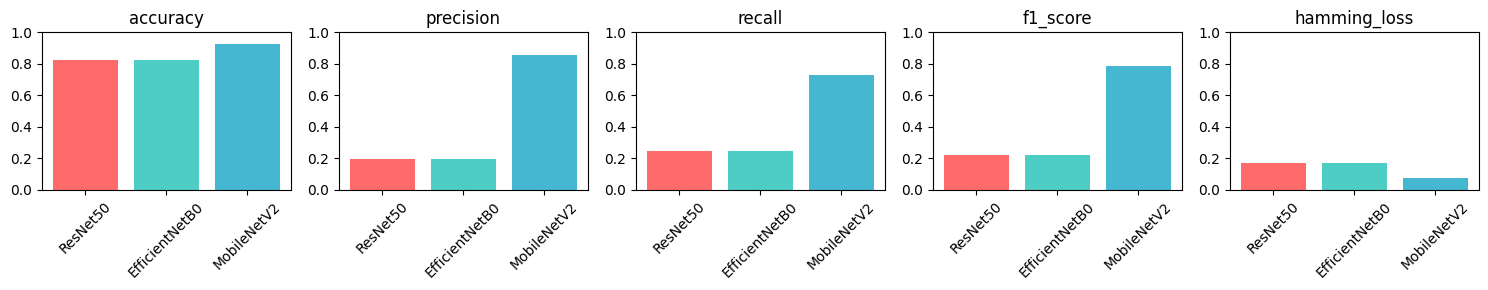

In [ ]:
results = pd.DataFrame({
    'ResNet50': metrics_resnet,
    'EfficientNetB0': metrics_efficient,
    'MobileNetV2': metrics_mobile
}).T

print("\n" + "="*60)
print("COMPARACIÓN")
print("="*60)
print(results.to_string())

best_model_name = results['f1_score'].idxmax()
best_f1 = results.loc[best_model_name, 'f1_score']
print(f"\n MEJOR: {best_model_name} (F1: {best_f1:.4f})")

# Gráfico
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, col in zip(axes, results.columns):
    ax.bar(results.index, results[col], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax.set_title(col)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## Fine-Tuning

In [ ]:
print(f"\n{'='*50}\n  Fine-Tuning {best_model_name} (capas congeladas + más epochs)\n{'='*50}")

# Crear modelo con TODAS las capas congeladas
model_ft, _ = create_model(best_model_name)

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

with mlflow.start_run(run_name=f"{best_model_name}_FineTuned"):
    # ✅ REGISTRAR PARÁMETROS
    mlflow.log_param("model", f"{best_model_name}_FineTuned")
    mlflow.log_param("base_model", best_model_name)
    mlflow.log_param("img_size", IMG_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", 20)
    mlflow.log_param("fine_tuning", True)

    # Entrenar más epochs con learning rate decreciente
    history = model_ft.fit(X_train, y_train, validation_data=(X_val, y_val),
                 batch_size=BATCH_SIZE, epochs=20, callbacks=callbacks, verbose=1)

    # ✅ REGISTRAR MÉTRICAS DE ENTRENAMIENTO
    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    metrics_ft = get_metrics(model_ft, X_test, y_test)

    # ✅ REGISTRAR MÉTRICAS FINALES
    for key, value in metrics_ft.items():
        mlflow.log_metric(f"test_{key}", value)

    # ✅ GUARDAR MODELO
    mlflow.keras.log_model(model_ft, artifact_path="model", registered_model_name=f"{best_model_name}_FineTuned")
    mlflow.set_tag("framework", "tensorflow")
    mlflow.set_tag("dataset", "Pascal2007")
    mlflow.set_tag("fine_tuned", "True")

print(f"\n Original F1: {best_f1:.4f} → Fine-Tuned F1: {metrics_ft['f1_score']:.4f}")


  Fine-Tuning MobileNetV2 (capas congeladas + más epochs)
Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.7635 - loss: 0.4276 - val_accuracy: 0.8902 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.8794 - loss: 0.2366 - val_accuracy: 0.8783 - val_loss: 0.2192 - learning_rate: 0.0010
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8830 - loss: 0.2132 - val_accuracy: 0.8807 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8920 - loss: 0.1981 - val_accuracy: 0.8974 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9036 - loss: 0.1835 - val_accuracy: 0.8807 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9157 - loss: 0.1567 - val_accuracy: 0.8926 - val_loss: 0.2233 - learning_rate: 0.0010
Epoch 7/20
123/123 ━

2026/02/03 17:01:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/03 17:01:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



 Original F1: 0.7839 → Fine-Tuned F1: 0.7775


Successfully registered model 'MobileNetV2_FineTuned'.
Created version '1' of model 'MobileNetV2_FineTuned'.


---
# Predicción Interactiva
---

In [ ]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Cargar mejor modelo
def load_best():
    exp = mlflow.get_experiment_by_name("MultiLabel_Pascal2007")
    # ✅ BUSCAR POR MÉTRICA CORRECTA (con prefijo test_)
    runs = mlflow.search_runs(experiment_ids=[exp.experiment_id], order_by=["metrics.test_f1_score DESC"])
    best = runs.iloc[0]
    print(f"Cargando: {best['tags.mlflow.runName']} (F1: {best['metrics.test_f1_score']:.4f})")
    # ✅ CARGAR DESDE ARTIFACT_PATH CORRECTO
    return mlflow.keras.load_model(f"runs:/{best['run_id']}/model")

current_model = load_best()

Cargando: MobileNetV2 (F1: 0.7839)


📁 Selecciona imágenes:


Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 7.png to 7.png
Saving 8.png to 8.png
Saving 9.png to 9.png
Saving 10.png to 10.png

✅ 10 imágenes


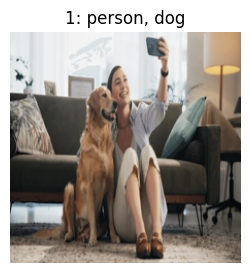

  person: 89%
  chair: 9%
  dog: 58%
  sofa: 2%


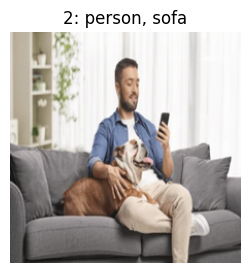

  person: 96%
  chair: 9%
  dog: 3%
  sofa: 86%


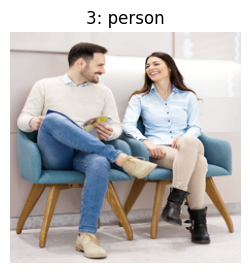

  person: 100%
  chair: 20%
  dog: 0%
  sofa: 48%


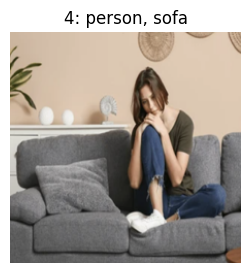

  person: 98%
  chair: 1%
  dog: 0%
  sofa: 94%


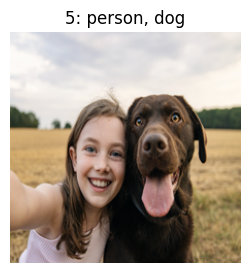

  person: 85%
  chair: 0%
  dog: 82%
  sofa: 0%


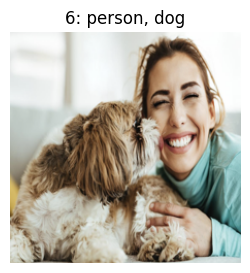

  person: 94%
  chair: 2%
  dog: 63%
  sofa: 1%


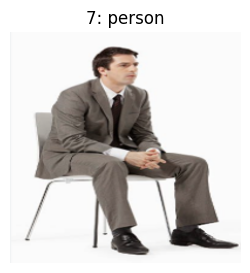

  person: 99%
  chair: 15%
  dog: 3%
  sofa: 10%


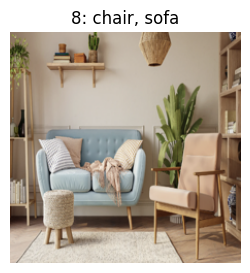

  person: 2%
  chair: 97%
  dog: 0%
  sofa: 53%


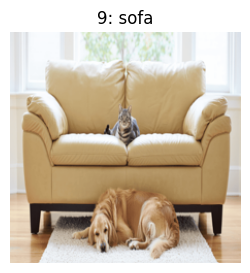

  person: 2%
  chair: 5%
  dog: 6%
  sofa: 73%


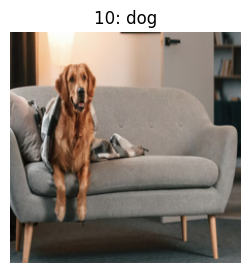

  person: 2%
  chair: 10%
  dog: 93%
  sofa: 40%


In [ ]:
# Subir imágenes
print("📁 Selecciona imágenes:")
uploaded = files.upload()

up_imgs = []
up_arrs = []
for fname, content in uploaded.items():
    img = Image.open(io.BytesIO(content)).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    up_imgs.append(img)
    up_arrs.append(np.array(img, dtype=np.float32) / 255.0)

print(f"\n✅ {len(up_imgs)} imágenes")

# Predecir
preds_arr = current_model.predict(np.array(up_arrs), verbose=0)
predictions = []
for pred in preds_arr:
    labels = [TARGET_CLASSES[i] for i, p in enumerate(pred) if p >= 0.5] or ['ninguna']
    probs = {TARGET_CLASSES[i]: float(pred[i]) for i in range(NUM_CLASSES)}
    predictions.append({'labels': labels, 'probs': probs})

# Mostrar
for i, (img, pred) in enumerate(zip(up_imgs, predictions)):
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(f"{i+1}: {', '.join(pred['labels'])}")
    plt.axis('off')
    plt.show()
    for c, p in pred['probs'].items():
        print(f"  {c}: {p:.0%}")

📝 Selecciona etiquetas correctas:

--- Imagen 1 ---


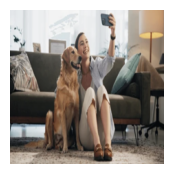


--- Imagen 2 ---


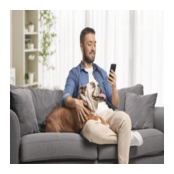


--- Imagen 3 ---


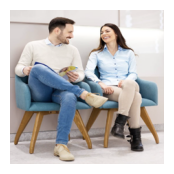


--- Imagen 4 ---


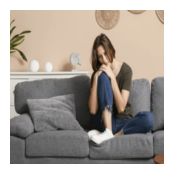


--- Imagen 5 ---


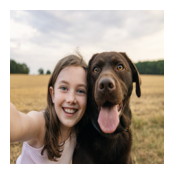


--- Imagen 6 ---


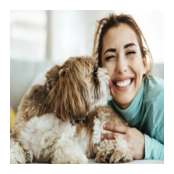


--- Imagen 7 ---


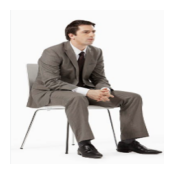


--- Imagen 8 ---


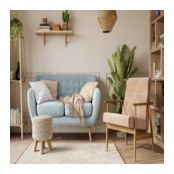


--- Imagen 9 ---


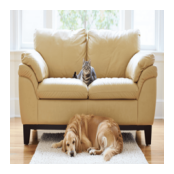


--- Imagen 10 ---


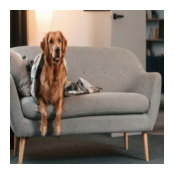


✅ Marca checkboxes, luego ejecuta siguiente celda


In [ ]:
# Seleccionar etiquetas correctas
all_cbs = []
print("📝 Selecciona etiquetas correctas:")

for i, img in enumerate(up_imgs):
    print(f"\n--- Imagen {i+1} ---")
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    cbs = {c: widgets.Checkbox(value=False, description=c) for c in TARGET_CLASSES}
    display(widgets.HBox(list(cbs.values())))
    all_cbs.append(cbs)

print("\n✅ Marca checkboxes, luego ejecuta siguiente celda")

In [ ]:
correct_labels = []
print("Etiquetas:")
for i, cbs in enumerate(all_cbs):
    sel = [c for c, cb in cbs.items() if cb.value]
    vec = [1.0 if c in sel else 0.0 for c in TARGET_CLASSES]
    correct_labels.append(vec)
    print(f"  {i+1}: {sel}")

if all(sum(v) == 0 for v in correct_labels):
    print("\n⚠️ Sin etiquetas")
else:
    X_new = np.array(up_arrs, dtype=np.float32)
    y_new = np.array(correct_labels, dtype=np.float32)

    # Repetir datos para más muestras
    X_rep = np.tile(X_new, (10, 1, 1, 1))
    y_rep = np.tile(y_new, (10, 1))

    print(f"Reentrenando con {len(X_new)} imágenes...")

    with mlflow.start_run(run_name="Retrained"):
        # ✅ REGISTRAR PARÁMETROS
        mlflow.log_param("model", "Retrained")
        mlflow.log_param("new_images", len(X_new))
        mlflow.log_param("retrain_epochs", 30)

        current_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        history = current_model.fit(X_rep, y_rep, batch_size=4, epochs=30, verbose=1)

        # ✅ REGISTRAR MÉTRICAS
        for epoch in range(len(history.history['loss'])):
            mlflow.log_metric("retrain_loss", history.history['loss'][epoch], step=epoch)
            mlflow.log_metric("retrain_accuracy", history.history['accuracy'][epoch], step=epoch)

        # ✅ GUARDAR MODELO
        mlflow.keras.log_model(current_model, artifact_path="model", registered_model_name="Retrained")
        mlflow.set_tag("retrained", "True")

    print("\n✅ Modelo reentrenado")

Etiquetas:
  1: ['person', 'dog', 'sofa']
  2: ['person', 'dog', 'sofa']
  3: ['person', 'chair']
  4: ['person', 'sofa']
  5: ['person', 'dog']
  6: ['person', 'dog']
  7: ['person', 'chair']
  8: ['chair', 'sofa']
  9: ['dog', 'sofa']
  10: ['dog', 'sofa']
Reentrenando con 10 imágenes...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7652 - loss: 0.5272
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6107 - loss: 0.3993
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6603 - loss: 0.2534
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7645 - loss: 0.2082
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6508 - loss: 0.1748
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6558 - loss: 0.1496
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6773 - loss: 0.1209
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6896 - loss: 0.1036
Epoch 9/30
25/25 ━━━━━━━━━━━━━━

2026/02/03 17:04:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/03 17:04:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



✅ Modelo reentrenado


Successfully registered model 'Retrained'.
Created version '1' of model 'Retrained'.



🔄 ANTES vs DESPUÉS


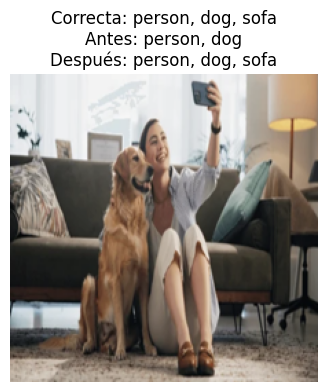

  person: 89% → 100% (↑11%)
  chair: 9% → 0% (↓9%)
  dog: 58% → 100% (↑42%)
  sofa: 2% → 97% (↑95%)


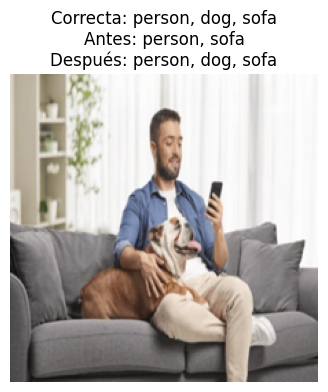

  person: 96% → 99% (↑3%)
  chair: 9% → 1% (↓9%)
  dog: 3% → 96% (↑93%)
  sofa: 86% → 99% (↑13%)


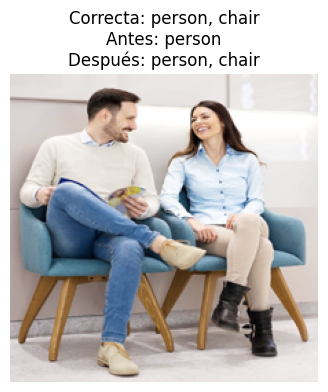

  person: 100% → 100% (↑0%)
  chair: 20% → 99% (↑79%)
  dog: 0% → 0% (↓0%)
  sofa: 48% → 2% (↓46%)


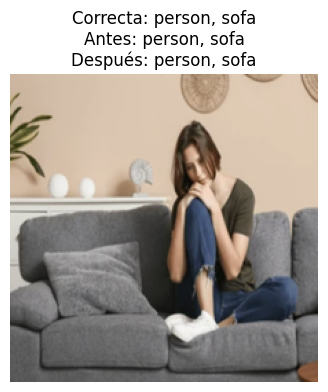

  person: 98% → 100% (↑2%)
  chair: 1% → 0% (↓1%)
  dog: 0% → 0% (↑0%)
  sofa: 94% → 100% (↑6%)


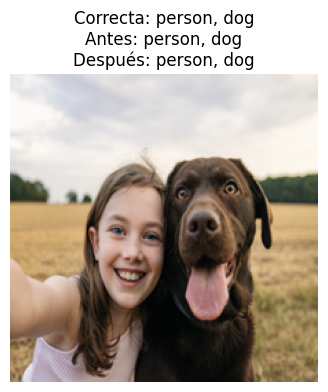

  person: 85% → 100% (↑15%)
  chair: 0% → 0% (↓0%)
  dog: 82% → 100% (↑18%)
  sofa: 0% → 0% (↓0%)


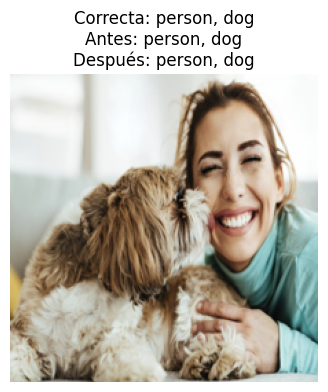

  person: 94% → 100% (↑6%)
  chair: 2% → 0% (↓2%)
  dog: 63% → 100% (↑37%)
  sofa: 1% → 0% (↓1%)


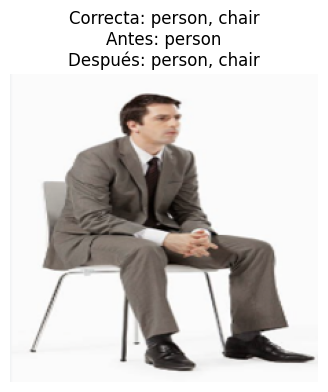

  person: 99% → 100% (↑1%)
  chair: 15% → 98% (↑84%)
  dog: 3% → 0% (↓3%)
  sofa: 10% → 1% (↓9%)


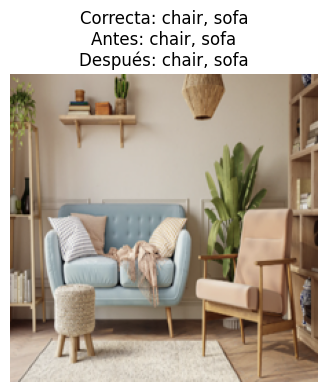

  person: 2% → 0% (↓1%)
  chair: 97% → 100% (↑3%)
  dog: 0% → 0% (↓0%)
  sofa: 53% → 99% (↑47%)


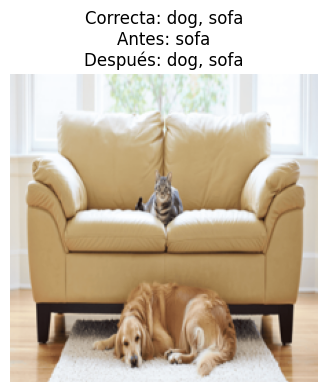

  person: 2% → 1% (↓2%)
  chair: 5% → 0% (↓5%)
  dog: 6% → 99% (↑93%)
  sofa: 73% → 99% (↑27%)


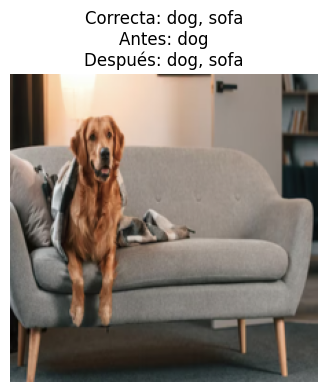

  person: 2% → 0% (↓1%)
  chair: 10% → 0% (↓9%)
  dog: 93% → 100% (↑7%)
  sofa: 40% → 100% (↑60%)


In [ ]:
# Comparar antes/después
new_preds_arr = current_model.predict(np.array(up_arrs), verbose=0)
new_predictions = []
for pred in new_preds_arr:
    labels = [TARGET_CLASSES[i] for i, p in enumerate(pred) if p >= 0.5] or ['ninguna']
    probs = {TARGET_CLASSES[i]: float(pred[i]) for i in range(NUM_CLASSES)}
    new_predictions.append({'labels': labels, 'probs': probs})

print("\n" + "="*50 + "\n🔄 ANTES vs DESPUÉS\n" + "="*50)
for i, (img, old, new) in enumerate(zip(up_imgs, predictions, new_predictions)):
    correct = [TARGET_CLASSES[j] for j, v in enumerate(correct_labels[i]) if v == 1.0]
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Correcta: {', '.join(correct)}\nAntes: {', '.join(old['labels'])}\nDespués: {', '.join(new['labels'])}")
    plt.axis('off')
    plt.show()

    for c in TARGET_CLASSES:
        diff = new['probs'][c] - old['probs'][c]
        print(f"  {c}: {old['probs'][c]:.0%} → {new['probs'][c]:.0%} ({'↑' if diff > 0 else '↓'}{abs(diff):.0%})")

In [ ]:
print("="*50 + "\nRESUMEN\n" + "="*50)
print(f"Dataset: Pascal 2007")
print(f"Clases: {TARGET_CLASSES}")
print(f"Modelos: ResNet50, EfficientNetB0, MobileNetV2")
print(f"Mejor: {best_model_name} (F1: {best_f1:.4f})")
print(f"Fine-Tuned F1: {metrics_ft['f1_score']:.4f}")
print(f"\n📁 MLflow guardado en: {os.path.abspath(mlflow_dir)}")
print("✅ Modelos en MLflow")

RESUMEN
Dataset: Pascal 2007
Clases: ['person', 'chair', 'dog', 'sofa']
Modelos: ResNet50, EfficientNetB0, MobileNetV2
Mejor: MobileNetV2 (F1: 0.7839)
Fine-Tuned F1: 0.7775

📁 MLflow guardado en: /content/mlruns
✅ Modelos en MLflow


##  Descargar MLflow


In [ ]:
# ✅ COMPRIMIR Y DESCARGAR MLFLOW
import shutil
from datetime import datetime

# Crear zip con timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_name = f"mlflow_pascal2007_{timestamp}"
print(f" Comprimiendo {mlflow_dir}...")
shutil.make_archive(zip_name, 'zip', mlflow_dir)
print(f" Creado: {zip_name}.zip")

# Descargar archivo
print(" Descargando...")
files.download(f"{zip_name}.zip")
print("\n ¡Descarga completa!")
print("\n Para usar localmente:")
print("   1. Descomprime el archivo ZIP")
print("   2. Abre terminal en la carpeta descomprimida")
print("   3. Ejecuta: mlflow ui")
print("   4. Abre http://localhost:5000 en tu navegador")

📦 Comprimiendo ./mlruns...
✅ Creado: mlflow_pascal2007_20260203_170515.zip
⬇️ Descargando...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 ¡Descarga completa!

📖 Para usar localmente:
   1. Descomprime el archivo ZIP
   2. Abre terminal en la carpeta descomprimida
   3. Ejecuta: mlflow ui
   4. Abre http://localhost:5000 en tu navegador


In [ ]:
#  Para descargar MLflow
import shutil
from datetime import datetime
from google.colab import files

# Verificar que existe el directorio
if os.path.exists("./mlruns"):
    # Crear zip con timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_name = f"mlflow_pascal2007_{timestamp}"
    print(f" Comprimiendo ./mlruns...")
    shutil.make_archive(zip_name, 'zip', './mlruns')
    print(f" Creado: {zip_name}.zip")

    # Descargar archivo
    print("⬇ Descargando...")
    files.download(f"{zip_name}.zip")
    print("\n ¡Descarga completa!")
else:
    print(" ERROR: No existe ./mlruns")
    print("Debes ejecutar primero las celdas de entrenamiento")

📦 Comprimiendo ./mlruns...
✅ Creado: mlflow_pascal2007_20260203_171139.zip
⬇️ Descargando...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 ¡Descarga completa!


**CONCLUSIONES**

1.- El Mejor modelo de los 3 probados fua MovileNetV2 superando por mucho a los otros 2.

2.- MobileNetV2     logor accuracy de 0.923628

3.- Al mejor modelo MovileNetV2 se aplico finne tunning logrando una leve mejora Original F1: 0.7661 → Fine-Tuned F1: 0.7878.

4.- Logramos un modelo con gran capacidad para predecir las clases entrenadas y un gran reentrenamiento.

**REFERENCIAS**
1. Everingham, M., Van Gool, L., Williams, C. K. I., Winn, J., & Zisserman, A. (2007). The PASCAL Visual Object Classes Challenge 2007 (VOC2007) [Conjunto de datos]. PASCAL Network of Excellence. http://host.robots.ox.ac.uk/pascal/VOC/voc2007/